In [1]:
from TrainAndTest.test import evaluate_classification_model
from Preprocessing.AudioPreprocessor import AudioHandler
from DatasetReaders.AudioDatset import AudioDataset
from DetectionModels.AudioCNN import CNNnetwork
from torch.utils.data import DataLoader
from TrainAndTest.train import train, EarlyStopping
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import nn
import torchaudio
import warnings
import librosa
import random
import torch

if torch.cuda.is_available():
    device="cuda"
else:
    device= "cpu"
print(device)
warnings.filterwarnings("ignore", message="At least one mel filterbank has all zero values", 
                        category=UserWarning, module="torchaudio.functional.functional")

cuda


## 1. Train and Validation Dataset Initialization

In [5]:
NUM_SAMPLES= int(3.876695758374233*16000)
BATCH_SIZE= 128
SAMPLE_RATE= 20000
NUM_OF_MELS= 128
WIN_LENGTH= int(0.016 * SAMPLE_RATE)
HOP_LENGTH= int(0.004 * SAMPLE_RATE) 
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\real"
CORRUPTED_PATHS=[
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file27206.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file15746.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file9875.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file32972.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file17450.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file27643.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file13424.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file30959.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file16643.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file5323.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file27839.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file17407.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file19851.mp3",
    r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\training\fake\file31017.mp3"
]

mel_spectrogram_transform= torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=WIN_LENGTH*2,
        hop_length=HOP_LENGTH,
        n_mels=NUM_OF_MELS,
        window_fn=torch.hamming_window,
        win_length=WIN_LENGTH
    ),
    torchaudio.transforms.AmplitudeToDB(top_db=80)
)
AudiHandler= AudioHandler(mel_spectrogram_transform, SAMPLE_RATE, NUM_SAMPLES, device)

audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectrogram_transform,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioHandler
)

real_indices= [i for i, label in enumerate(audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 4000)
fake_sample= random.sample(fake_indices, 4000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
small_train_dataset= Subset(audio_dataset, subset_indices)

In [6]:
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\validation\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\validation\real"


val_audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectrogram_transform,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioHandler
)

real_indices= [i for i, label in enumerate(val_audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(val_audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 1000)
fake_sample= random.sample(fake_indices, 1000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
small_val_dataset= Subset(val_audio_dataset, subset_indices)

## 2. Model training

In [7]:
train_data_loader= DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
)
val_data_loader= DataLoader(
    small_val_dataset,
    batch_size= BATCH_SIZE
)
early_stopper = EarlyStopping(patience=5)
model= CNNnetwork().to(device)
print(model)
loss_fn= nn.CrossEntropyLoss()
optimiser= torch.optim.Adam(model.parameters(), lr=0.001)

CNNnetwork(
  (dropout_dense): Dropout(p=0.5, inplace=False)
  (dropout_conv): Dropout(p=0.25, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [8]:
torch.manual_seed(42)
train_loss, val_loss= train(model, train_data_loader, loss_fn, optimiser, device, 100, early_stopper, val_data_loader)
torch.save(model.state_dict(), "Audio_CNN.pth")
print("model trained and stored")

epoch 1
loss: 0.8779617588198374
Validation Loss: 0.26570695638656616
epoch 2
loss: 0.2836268962848754
Validation Loss: 0.1733294166624546
epoch 3
loss: 0.22025977953204087
Validation Loss: 0.22042824048548937
EarlyStopping counter: 1/5
epoch 4
loss: 0.14879318013314216
Validation Loss: 0.0935570802539587
epoch 5
loss: 0.07154476410517144
Validation Loss: 0.05352829140610993
epoch 6
loss: 0.07443826959749299
Validation Loss: 0.02391449103015475
epoch 7
loss: 0.02794099507099461
Validation Loss: 0.0097825060292962
epoch 8
loss: 0.0243981493579682
Validation Loss: 0.015723203163361177
EarlyStopping counter: 1/5
epoch 9
loss: 0.1321794325116253
Validation Loss: 0.1967055881395936
EarlyStopping counter: 2/5
epoch 10
loss: 0.09159900343215596
Validation Loss: 0.02495747123612091
EarlyStopping counter: 3/5
epoch 11
loss: 0.04263768323312794
Validation Loss: 0.01076850775280036
EarlyStopping counter: 4/5
epoch 12
loss: 0.013717472994892252
Validation Loss: 0.003835713851003675
epoch 13
loss: 

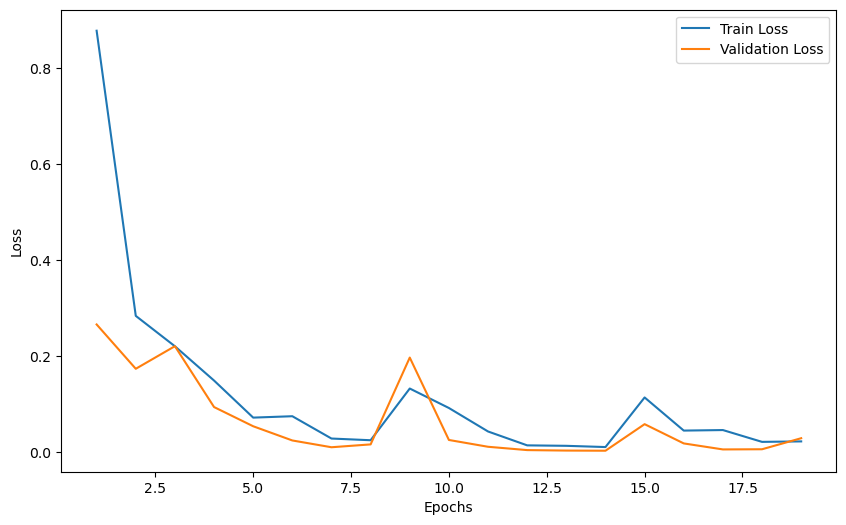

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10,6))
plt.plot(range(1, len(train_loss)+1), train_loss, label= "Train Loss")
plt.plot(range(1, len(val_loss)+1), val_loss, label= "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show();

## 3. Model Testing

In [10]:
torch.manual_seed(0)

model= CNNnetwork()
state_dict= torch.load("Audio_CNN.pth", weights_only=True)
model.load_state_dict(state_dict=state_dict)
model.eval()

real_indices= [i for i, label in enumerate(audio_dataset.labels) if label == 0]
fake_indices= [i for i, label in enumerate(audio_dataset.labels) if label == 1]
real_sample= random.sample(real_indices, 100)
fake_sample= random.sample(fake_indices, 150)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
test_dataset= Subset(audio_dataset, subset_indices)
test_loader= DataLoader(test_dataset, batch_size=128, shuffle=True)

acc, prec, rec, f1= evaluate_classification_model(model, test_loader, device)

Accuracy: 0.9840
Precision: 0.9844
Recall: 0.9840
F1-score: 0.9839


In [11]:
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\testing\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-original\for-original\testing\real"

valid_audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectrogram_transform,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS,
    AudioHandler
)

real_indices= [i for i, label in enumerate(valid_audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(valid_audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 1000)
fake_sample= random.sample(fake_indices, 1000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
valid_dataset= Subset(valid_audio_dataset, subset_indices)
valid_loader= DataLoader(valid_dataset, batch_size=128, shuffle=True)

acc, prec, rec, f1= evaluate_classification_model(model, valid_loader, device)

Accuracy: 0.8885
Precision: 0.8996
Recall: 0.8885
F1-score: 0.8877
